Imports

In [11]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random

sys.path.insert(0,'../')
from model_functions import *
from environment import env
config = env.env()
#Import Models
sys.path.insert(0,'../03_nps_models')
from tfidf_model import TfidfClassifier
from spacy_model import *
from get_context import *
from nltk_model import *


Test Data

In [2]:
test_data = pd.read_csv('../02_nps_api_data/testing_queries.csv')
test_data.columns = ['query', 'intent', 'endpoint', 'parkcode']
test_data.head()

,query,intent,endpoint,parkcode
0,Give me information on De Soto,description,parks,deso
1,Give me information on Bent's Old Fort Nationa...,description,parks,beol
2,Give me information on Vicksburg National Mili...,description,parks,vick
3,Give me information on Appomattox,description,parks,apco
4,Give me information on Dinosaur,description,parks,dino


In [3]:
len(test_data)

888

In [ ]:
test_data = test_data.sample(100, random_state=10)

Models

In [9]:
spacy_model = spacy_model_functions #from spacy_model.py
nltk_model = nltk_model_functions #from nltk_model.py
tfidf_model = pickle.load(open('../03_nps_models/tfidf_model.pkl','rb'))
gpt_model = nps_model_functions

models = {'gpt': gpt_model,
          'spacy': spacy_model, 
          'nltk' : nltk_model,
          'tfidf': tfidf_model,
          }

Test Output

In [5]:
def test_output(query, models):
    for model in models:
        endpoint, park_code, intent = models[model].get_params(query)
        print(model, ':', endpoint, park_code, intent)

In [6]:
query = 'What state is Green Springs in?'
test_output(query, models)

gpt : parks grsp state
spacy : parks grsp state
nltk : parks grsp state
tfidf : parks grsp state


In [12]:
query = 'List the amenities at Zion'
test_output(query, models)

gpt : amenities zion amenities
spacy : parks None other


ValueError: Park not found in the query. Please provide a valid park name.

In [ ]:
query = 'What is the fee for Yosemite?'
test_output(query, models)

gpt : fees yose feespass
spacy : parks None other
tfidf : feespasses yose feespass


Create Test Output Data Frame

In [6]:
def create_test_data (query_df, models):
    """ Input is test data in a data frame with query, intent, endpoing, and parkcode
        Output is the test data frame with predicted intent, endpoint and parkcode
        for each model
    """
    for model in models:
        tempt_df = query_df.apply(lambda x: models[model].get_params(x['query']), result_type='expand', axis=1)
        tempt_df.columns = [f'{model}_endpoint', f'{model}_parkcode', f'{model}_intent']
        query_df = pd.concat([query_df, tempt_df], axis=1)
        query_df = query_df.fillna('none')
    return query_df

In [7]:
test_data = create_test_data(test_data, models)
#26.2 sec for spacy + tfidf

In [8]:
test_data.head()

,query,intent,endpoint,parkcode,spacy_endpoint,spacy_parkcode,spacy_intent,tfidf_endpoint,tfidf_parkcode,tfidf_intent
0,Give me information on De Soto,description,parks,deso,parks,none,other,parks,deso,description
1,Give me information on Bent's Old Fort Nationa...,description,parks,beol,parks,beol,other,parks,beol,description
2,Give me information on Vicksburg National Mili...,description,parks,vick,parks,vick,other,parks,vick,description
3,Give me information on Appomattox,description,parks,apco,parks,none,other,parks,lyba,description
4,Give me information on Dinosaur,description,parks,dino,parks,none,other,parks,lyba,description


Model Accuracy

In [18]:
metrics = ['intent', 'endpoint', 'parkcode']

In [19]:
def plot_accuracy(df, metric): 
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df[metric], palette='YlGn')
    #sns.barplot(x='RecreationVisits', y='Full_ParkName', data=df, palette='YlGn')
    plt.xlabel('API Model')
    plt.ylabel('Accuracy')
    plt.title(f'Model Accuracy on {metric.capitalize()}')
    plt.show()

/var/folders/lq/0q3fzmb57s3c187k6gjyx3_00000gn/T/ipykernel_9550/3266048973.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df[metric], palette='YlGn')


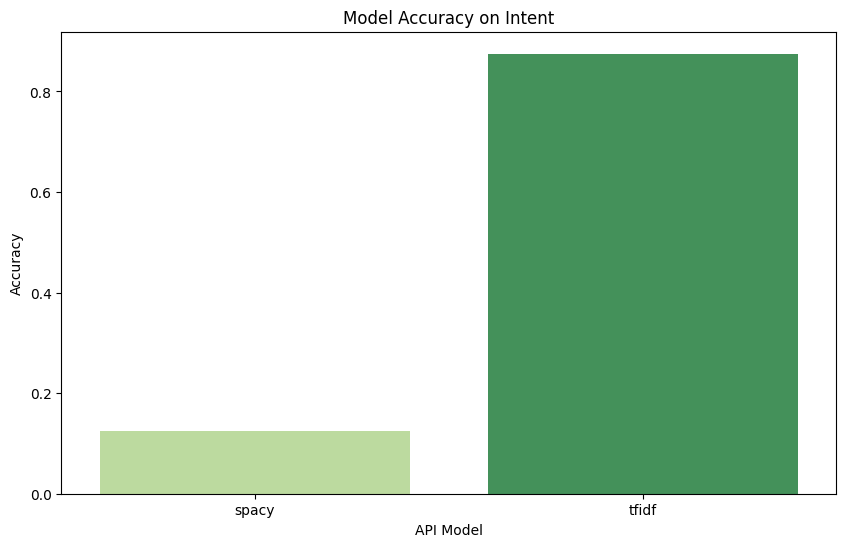

/var/folders/lq/0q3fzmb57s3c187k6gjyx3_00000gn/T/ipykernel_9550/3266048973.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df[metric], palette='YlGn')


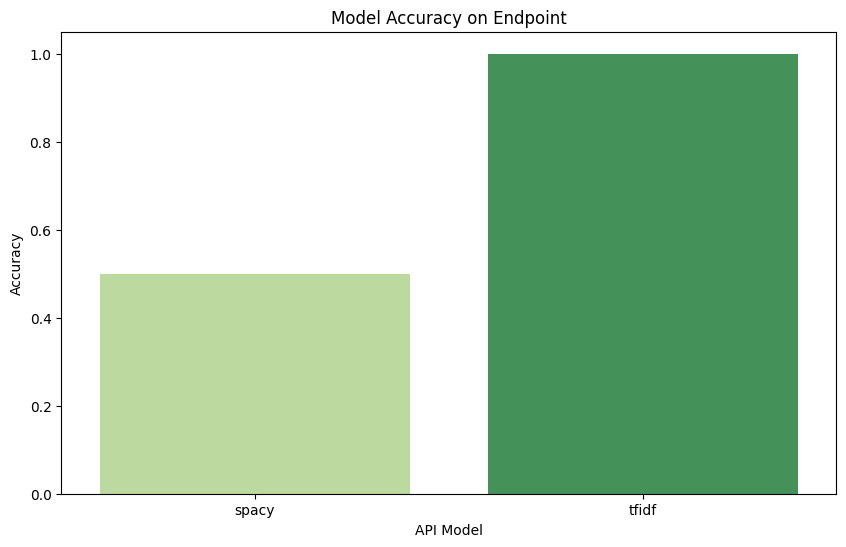

/var/folders/lq/0q3fzmb57s3c187k6gjyx3_00000gn/T/ipykernel_9550/3266048973.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df[metric], palette='YlGn')


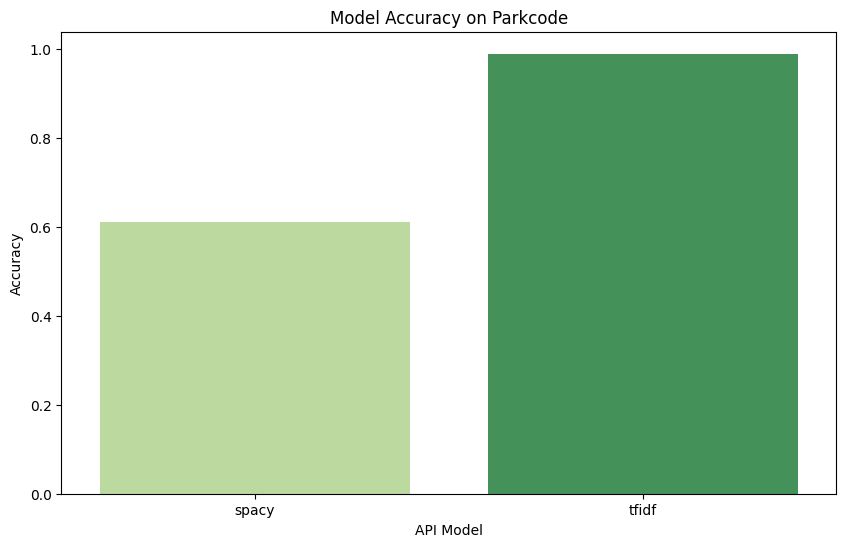

In [24]:
def model_accuracy (df, metrics, models):
    acc_df = pd.DataFrame(columns = metrics)
    for metric in metrics:
        for model in models:
            acc_df.loc[model,metric] = len(df.query(f'{metric}=={model}_{metric}'))/len(df)
        plot_accuracy(acc_df, metric)
    return acc_df

accuracy_df = model_accuracy(test_data, metrics, models)



In [220]:
accuracy_df

,intent,endpoint,parkcode
gpt,1.0,0.91,0.98
spacy,0.02,0.27,0.57
nltk,0.02,0.27,0.46
tfidf,0.93,0.86,1.0


In [25]:
accuracy_df

,intent,endpoint,parkcode
spacy,0.125,0.5,0.611486
tfidf,0.875,1.0,0.988739


In [22]:
accuracy_df

,intent,endpoint,parkcode
gpt,1.0,0.91,0.98
spacy,0.02,0.27,0.57


Errors

In [225]:
def top_errors (df, metrics, models):
    errors_df = pd.DataFrame(columns = metrics)
    for metric in metrics:
        right = '&'.join([f'{metric}=={model}_{metric}' for model in models])
        wrong = '&'.join([f'{metric}!={model}_{metric}' for model in models])
        #errors_df.loc['total', metric] = len(df)
        errors_df.loc['all_right', metric] = len(df.query(right))
        errors_df.loc['all_wrong', metric] = len(df.query(wrong))
        for indx, model in enumerate(models):
            other_models = models[:indx]+models[indx+1:]
            right_model = '&'.join([f'{metric}=={model}_{metric}']+[f'{metric}!={mod}_{metric}' for mod in other_models])
            wrong_model = '&'.join([f'{metric}!={model}_{metric}']+[f'{metric}=={mod}_{metric}' for mod in other_models])
            errors_df.loc[f'only_{model}', metric] = len(df.query(right_model))
            errors_df.loc['_and_'.join([mod for mod in other_models])] = len(df.query(wrong_model))
    return errors_df

errors = top_errors(test_data, ['intent', 'endpoint', 'parkcode'], ['gpt', 'spacy', 'nltk',])# 'tfidf'])
errors

,intent,endpoint,parkcode
all_right,2,27,44
all_wrong,0,9,0
only_gpt,98,64,43
spacy_and_nltk,2,2,2
only_spacy,0,0,0
gpt_and_nltk,0,0,0
only_nltk,0,0,0
gpt_and_spacy,11,11,11


In [226]:
def plot_errors(error_df):
    for metric in error_df.columns:
        colors = sns.color_palette('YlGn')[1:8]
        plt.figure(figsize=(10, 7))
        temp_df = error_df.query(f'{metric}>0')
        plt.pie(temp_df[metric], labels=temp_df.index, colors=colors, autopct='%1.1f%%')
        plt.title(f'Accurate Outcomes for {metric.capitalize()}')
        plt.show()

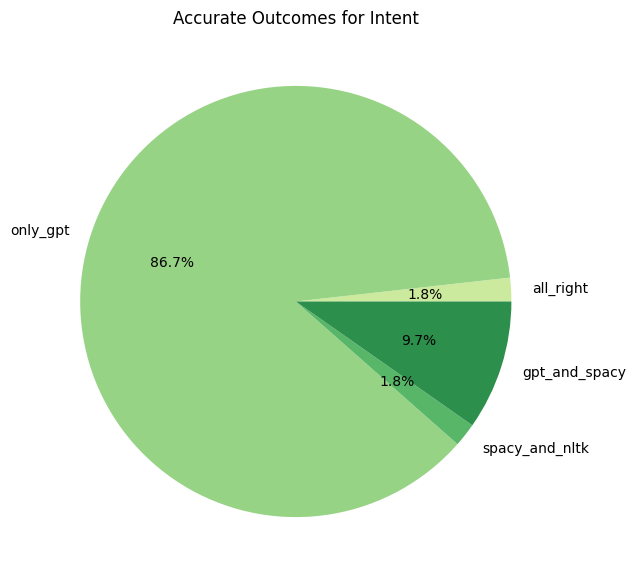

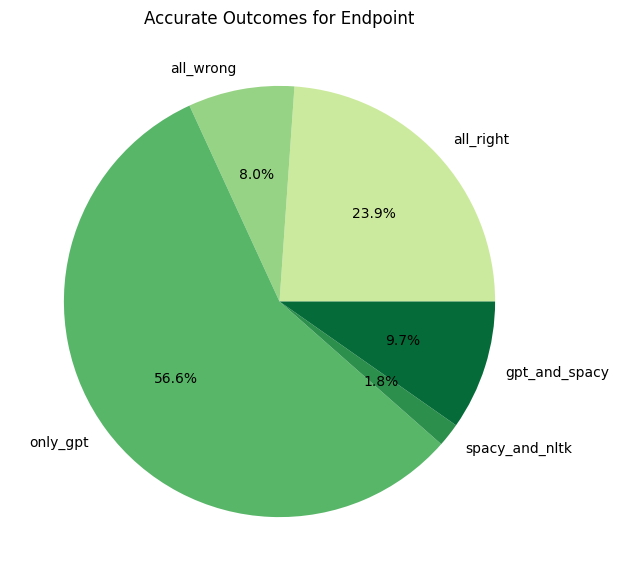

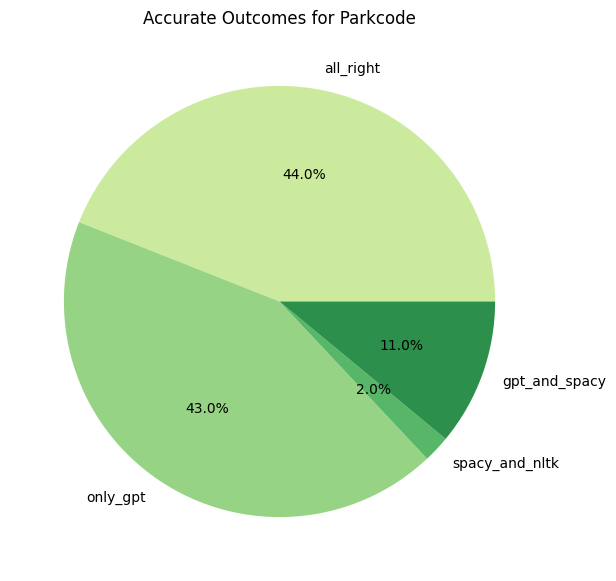

In [227]:
plot_errors(errors)

In [220]:
errors

,intent,endpoint,parkcode
total,100,100,100
right,2,27,47
wrong,0,9,13


In [24]:
errors

,intent,endpoint,parkcode
total,100,100,100
right,2,27,55
wrong,0,9,0


In [228]:
def find_wrong(df, metric, model):
    wrong = df.query(f'{metric}!={model}_{metric}')
    wrong = wrong[[metric, f'{model}_{metric}']].value_counts()

    return wrong

In [56]:
find_wrong(test_data, 'intent', 'gpt')

Series([], Name: count, dtype: int64)

In [57]:
find_wrong(test_data, 'endpoint', 'gpt')

endpoint    gpt_endpoint
feespasses  fees            9
Name: count, dtype: int64

In [58]:
find_wrong(test_data, 'parkcode', 'gpt')

parkcode  gpt_parkcode
fomr      fom             1
jofl      jof             1
Name: count, dtype: int64

In [59]:
find_wrong(test_data, 'intent', 'spacy')

intent       spacy_intent
amenities    none            11
events       other           10
description  other            9
fullname     other            9
alerts       other            8
address      none             7
             other            7
amenities    other            6
feespass     other            6
fullname     none             6
state        none             5
description  none             4
events       none             4
alerts       none             3
feespass     none             3
Name: count, dtype: int64

In [60]:
find_wrong(test_data, 'endpoint', 'spacy')


endpoint    spacy_endpoint                                                
parks       Park not found in the query. Please provide a valid park name.    22
amenities   Park not found in the query. Please provide a valid park name.    11
events      parks                                                             10
alerts      parks                                                              8
amenities   parks                                                              6
feespasses  parks                                                              6
events      Park not found in the query. Please provide a valid park name.     4
alerts      Park not found in the query. Please provide a valid park name.     3
feespasses  Park not found in the query. Please provide a valid park name.     3
Name: count, dtype: int64

In [61]:
find_wrong(test_data, 'parkcode', 'spacy')


parkcode  spacy_parkcode
nebe      none              3
casa      none              3
samo      none              2
elca      none              2
upde      none              2
tuin      none              2
hove      none              2
sand      none              2
cari      none              2
aleu      none              2
saga      none              2
foda      none              2
adam      none              1
roca      none              1
popo      none              1
ston      none              1
tosy      none              1
rabr      none              1
fols      none              1
neri      none              1
efmo      none              1
deso      none              1
cave      none              1
cach      none              1
bisc      none              1
biho      none              1
bepa      none              1
apco      none              1
waca      none              1
Name: count, dtype: int64

In [144]:
find_wrong(test_data, 'intent', 'nltk')

intent       nltk_intent
amenities    none           11
events       other          10
description  other           9
fullname     other           9
alerts       other           8
address      none            7
             other           7
amenities    other           6
feespass     other           6
fullname     none            6
state        none            5
description  none            4
events       none            4
alerts       none            3
feespass     none            3
Name: count, dtype: int64

In [145]:
find_wrong(test_data, 'endpoint', 'nltk')

endpoint    nltk_endpoint                                                 
parks       Park not found in the query. Please provide a valid park name.    22
amenities   Park not found in the query. Please provide a valid park name.    11
events      parks                                                             10
alerts      parks                                                              8
amenities   parks                                                              6
feespasses  parks                                                              6
events      Park not found in the query. Please provide a valid park name.     4
alerts      Park not found in the query. Please provide a valid park name.     3
feespasses  Park not found in the query. Please provide a valid park name.     3
Name: count, dtype: int64

In [146]:
find_wrong(test_data, 'parkcode', 'nltk')

parkcode  nltk_parkcode
kaho      saga             4
nebe      none             3
casa      none             3
samo      none             2
wapa      saga             2
nepe      saga             2
upde      none             2
tuin      none             2
cari      none             2
sand      none             2
aleu      none             2
elca      none             2
foda      none             2
saga      none             2
hove      none             2
roca      none             1
adam      none             1
popo      none             1
ston      none             1
tosy      none             1
waca      none             1
rabr      none             1
kewe      saga             1
neri      none             1
natr      bawa             1
fols      none             1
efmo      none             1
deso      none             1
cave      none             1
cach      none             1
bisc      none             1
biho      none             1
bepa      none             1
apco      none     

In [229]:
find_wrong(test_data, 'intent', 'tfidf')

intent  tfidf_intent
state   description     7
Name: count, dtype: int64

In [230]:
find_wrong(test_data, 'parkcode', 'tfidf')

Series([], Name: count, dtype: int64)

In [231]:
find_wrong(test_data, 'endpoint', 'tfidf')

endpoint  tfidf_endpoint
parks     addresses         14
Name: count, dtype: int64